# Recovering zero-inflated truncated distribution parameters with pymc

In [21]:
import pymc as pm
import pandas as pd
import numpy as np
from scipy.stats import poisson
from matplotlib import pyplot as plt
import arviz as az

In [2]:
#inspired by https://stackoverflow.com/questions/52398903/scipy-poisson-distribution-with-an-upper-limit

def sample(rng_generator, n, pi, l, ubound=7, ):
    obs = rng_generator.binomial(1, 1 - pi, size=n)
    non_zeros = len(obs[obs == 1])
    cutoff = poisson.cdf(ubound, l)
    u = rng_generator.uniform(high=cutoff, size=non_zeros)
    truncated_poisson = poisson.ppf(u, l)
    obs[obs == 1] = truncated_poisson
    return obs

In [3]:
rng = np.random.default_rng(42*42)
n = 3000

df = pd.DataFrame({
    "control" : sample(rng, n, 0.3, 4, 7),
    "treatment1" : sample(rng, n, 0.25, 4, 7),
    "treatment2" : sample(rng, n, 0.3, 4.5, 7),
    "treatment3" : sample(rng, n, 0.38, 4.5, 7),
})

long_df = df.melt(value_vars=df.columns, value_name='count', var_name='group')
group_idx, groups = long_df['group'].factorize(sort=True)


In [4]:
from pymc.distributions.discrete import _zero_inflated_mixture, Poisson

class ZeroInflatedPoissonTrunc:    

    def __new__(cls, name, psi, mu, **kwargs):
        pois = Poisson.dist(mu=mu)
        trunc_pois = pm.Truncated.dist(pois, lower=0, upper=7)
        return _zero_inflated_mixture(
            name=name, nonzero_p=psi, nonzero_dist=trunc_pois, **kwargs
        )

    @classmethod
    def dist(cls, psi, mu, **kwargs):
        pois = Poisson.dist(mu=mu)
        trunc_pois = pm.Truncated.dist(pois, lower=0, upper=7)
        return _zero_inflated_mixture(
            name=None, nonzero_p=psi, nonzero_dist=trunc_pois, **kwargs
        )

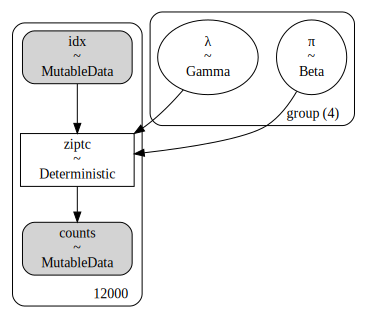

In [5]:
with pm.Model(coords={
    "group": groups.to_list()
}
) as truncated_model:
    
    counts = pm.MutableData("counts", long_df['count'])    
    idx = pm.MutableData("idx", group_idx)

    pi = pm.Beta('π', alpha=3, beta=7, dims="group")
    l = pm.Gamma('λ', alpha=4, beta=1, dims="group")

    zeroinfl_dist = ZeroInflatedPoissonTrunc("ziptc", psi=1-pi[idx], mu=l[idx], observed=counts) 

pm.model_to_graphviz(truncated_model)

In [6]:
with truncated_model:
    truncated_idata = pm.sample(chains=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [π, λ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 87 seconds.


In [7]:
az.summary(truncated_idata, kind="stats", hdi_prob=0.95, round_to=2).drop('sd', axis=1)

,mean,hdi_2.5%,hdi_97.5%
π[control],0.28,0.27,0.30
π[treatment1],0.24,0.22,0.25
π[treatment2],0.29,0.28,0.31
π[treatment3],0.38,0.37,0.40
λ[control],3.98,3.88,4.09
λ[treatment1],4.03,3.93,4.13
λ[treatment2],4.41,4.30,4.53
λ[treatment3],4.46,4.33,4.58


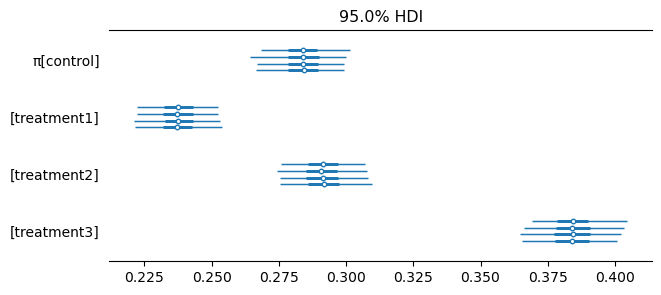

In [22]:
az.plot_forest(truncated_idata, var_names="π", hdi_prob=0.95, figsize=(7,3), textsize=10)
plt.savefig("images/pymc-π-estimates.png")

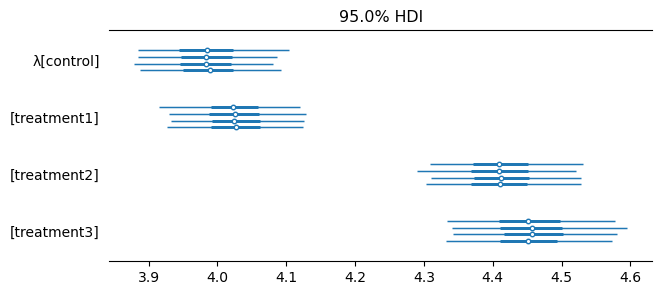

In [23]:
az.plot_forest(truncated_idata, var_names="λ", hdi_prob=0.95, figsize=(7,3), textsize=10)
plt.savefig("images/pymc-λ-estimates.png")